### Equations:

$$
\frac{dm}{dt} = m_0 H^+(I)H^-(p_2[t-t_i]) - m/g_m
$$

$$
\frac{dp}{dt} = p_0 m - kp(p+i_d) - p/g_p
$$

$$
\frac{dp_2}{dt} = kpp - p_2/g_p
$$

$$
\frac{dp_{i_d}}{dt} = k p i_d - p_{i_d}/g_p
$$

## ----------------------------------------------

$$
\frac{dm_a}{dt} = m_{a0} H^-(p_2+\epsilon p_{i_d}) - m_a/g_a
$$

$$
\frac{da}{dt} = a_0 m_a - ka(a+i_d) - a/g_a
$$

$$
\frac{da_2}{dt} = kaa - a_2/g_a
$$

$$
\frac{da_{i_d}}{dt} = k a i_d - a_{i_d}/g_a
$$

In [1]:
import numpy as np
import pylab as plt
from pydelay import dde23
import auxiliary_functions as aux
import seaborn as sns

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

In [2]:
params = {'tf' : 6000.0,  'dt' : 1.0                    # total time in min, step time
         ,'gm' : 24.0/np.log(2), 'gp' : 22.0/np.log(2)  # degradation rates HES RNA and protein, respectively
         ,'ga' : 50.0/np.log(2)                         # degradation rate target downstream gene
         ,'ti' : 1.9e+1                                 # intronic delay 
         ,'h0' : 1.0e+3, 'n'  : 5.0, 'nI' : 1.0         # Hill parameters for NICD activation of HES
         ,'k'  : 2.0e-1                                 # Homo and hetero dimer formation rate
         ,'m0' : 2.0e+2, 'p0' : 2.0                     # RNA and protein basic production rates
         ,'ma0': 2.0e+0, 'a0' : 0.1, 'na' : 2.0        # target gene production rate and Hill coeficient
         ,'e'  : 0.5e+0                                 # affinity rate between HES-ID and HES-HES on class-C sites
         ,'id' : 0.0e+0, 'I'  : 5.0e+2                  # amount of ID and NICD   
         ,'l'  : 0.0
         } 
eqns   = {'m' : 'm0*Hp(I,h0,nI)*HS(pp(t-ti),h0,n, l) - m/gm'  
         ,'p' : 'p0*m   - k*p*(p + id) - p/gp'
         ,'pp': 'k*p*p  - pp/gp'
         ,'pi': 'k*p*id - pi/gp'
         ,'ma': 'ma0*Hn(pp+e*pi,h0,na) - ma/ga'
         ,'a' : 'a0*ma - k*a*(a+id)  - a/ga'
         ,'aa': 'k*a*a - aa/ga'
         }
# ------ Setting initial condictions -------------
ic = {'m' : 0.0, 'p' : 0.0, 'pp': 0.0, 'pi': 0.0
     ,'ma': 0.0, 'a' : 0.0, 'aa': 0.0
     }
ic_dic = {'t': np.arange(0.0, params['ti']+params['dt'], params['dt'])}
for k in eqns.keys():
    ic_dic[k] = ic[k]*np.ones(len(ic_dic['t']))
# ------------------------------------------------
       
mycode = """
double Hn(double y, double y0, double n) {
    return 1.0/(1.0 + pow(y/y0, n));     }
double Hp(double y, double y0, double n) {
    return 1.0 - Hn(y, y0, n);           }
double HS(double y, double y0, double n, double lambda) {
    return Hn(y, y0, n) + lambda*Hp(y, y0, n);           }
"""
dde = dde23(eqns=eqns, params=params, supportcode=mycode)
dde.hist_from_arrays(ic_dic)
dde.set_sim_params(tfinal=params['tf'], RelTol=1e-3, AbsTol=1e-3, dtmax=0.5, dtmin=1e-2, dt0=0.1, MaxIter=1e+6)
dde.run()

In [3]:
p_dic = {'I' : 2**np.arange(-1.0, 14.1, 0.3)
        ,'id': 2**np.arange(-1.0, 14.1, 1.0)
        ,'m0': np.arange(10, 501, 10)
        ,'gp': np.arange(10, 51, 2)/np.log(2)
        ,'ti': np.arange(10.0, 26.0, 1)
        ,'l' : np.arange(0.0, 0.051, 0.001)}
label = {'m' : 'HES mRNA (log2)',         'pp': 'HES-HES (log2)',          'pi': 'HES-ID (log2)',
         'ma': 'Proneural mRNA (log2)',   'a' : 'Proneural levels (log2)', 'aa': 'Proneural levels (log2)', 
         'I' : 'Notch signal (log2)',     'id': 'ID levels (log2)',        'm0': 'Hes production rate \n (mRNA/min)',
         'gp': 'Hes protein half-life (min)',  'l': 'Autorepression factor','ti': 'intronic delay (min)'}
cmap = plt.cm.coolwarm
cmap.set_under(color='white')   
trange=[params['tf']-500, params['tf']]

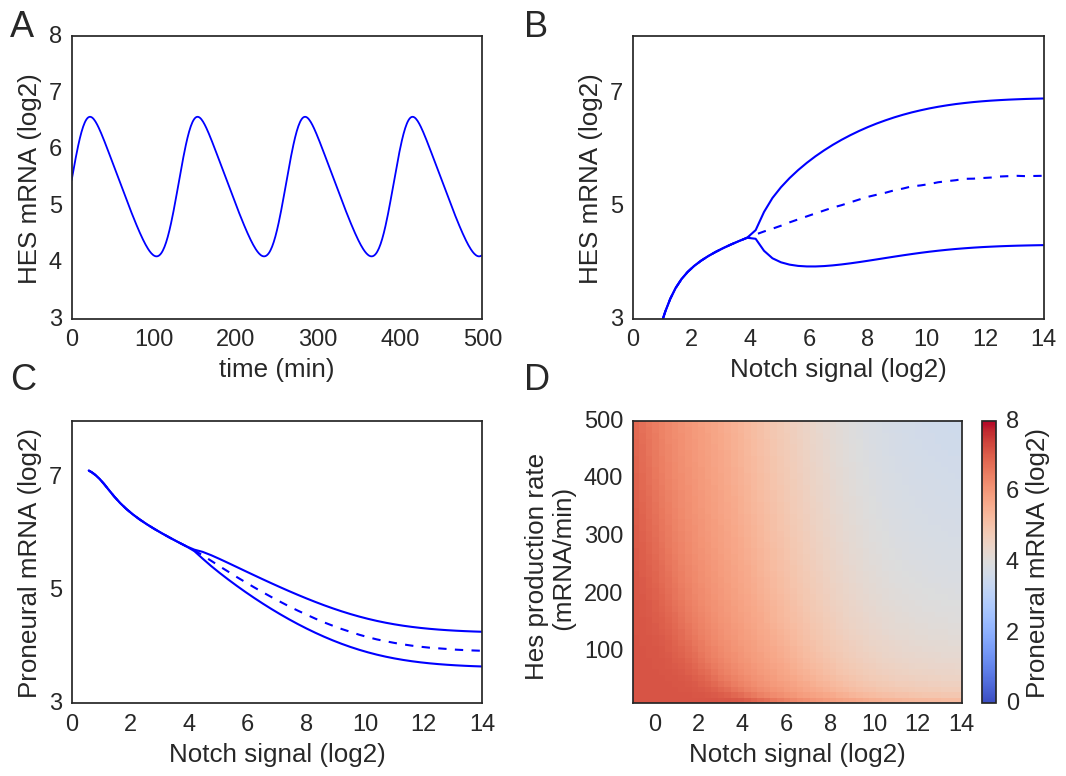

In [4]:
# ------------------- Figure 2 ----------------------------
s = aux.solve_eqs(dde, trange=trange, dtmax=params['dt'])

f = plt.subplots(2, 2, figsize=(5.5*2, 4*2), sharey=False)
ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax.text(-.15, 1.00, 'A', fontsize=26, transform=ax.transAxes)
ax.text(1.10, 1.00, 'B', fontsize=26, transform=ax.transAxes)
ax.text(-.15, -.25, 'C', fontsize=26, transform=ax.transAxes)
ax.text(1.10, -.25, 'D', fontsize=26, transform=ax.transAxes)
plt.plot(s['t'], s['m'], '-', c='b')
plt.ylabel(label['m'])
plt.xlabel('time (min)')
plt.ylim([3.0, 8.0])
plt.yticks(np.arange(3.0, 8.1, 1.0))
plt.xticks(np.arange(trange[0], trange[1]+1, 100), np.arange(0, 501, 100))

ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.bifurcation(dde, 'I', p_dic['I'], 'm', trange, label=label, log2=True, yrange=[3.0, 8.0], ax=ax, xlim=[0,14])

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.bifurcation(dde, 'I', p_dic['I'],'ma', trange, label=label, log2=True, yrange=[3.0, 8.0], ax=ax, xlim=[0,14])


m = aux.phase_diagram(dde, p_dic, axis=['I', 'm0'], var=['m', 'pp', 'ma', 'aa'], trange=trange)
ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['ma'], p_dic, axis=['I', 'm0'], label=label, clim=[0, 8], cmap=cmap, ax=ax, 
                  clabel=label['ma'], ylog=False)
plt.tight_layout()
#plt.savefig('../figures/Figure2_Notch_Hes.pdf', format='pdf')

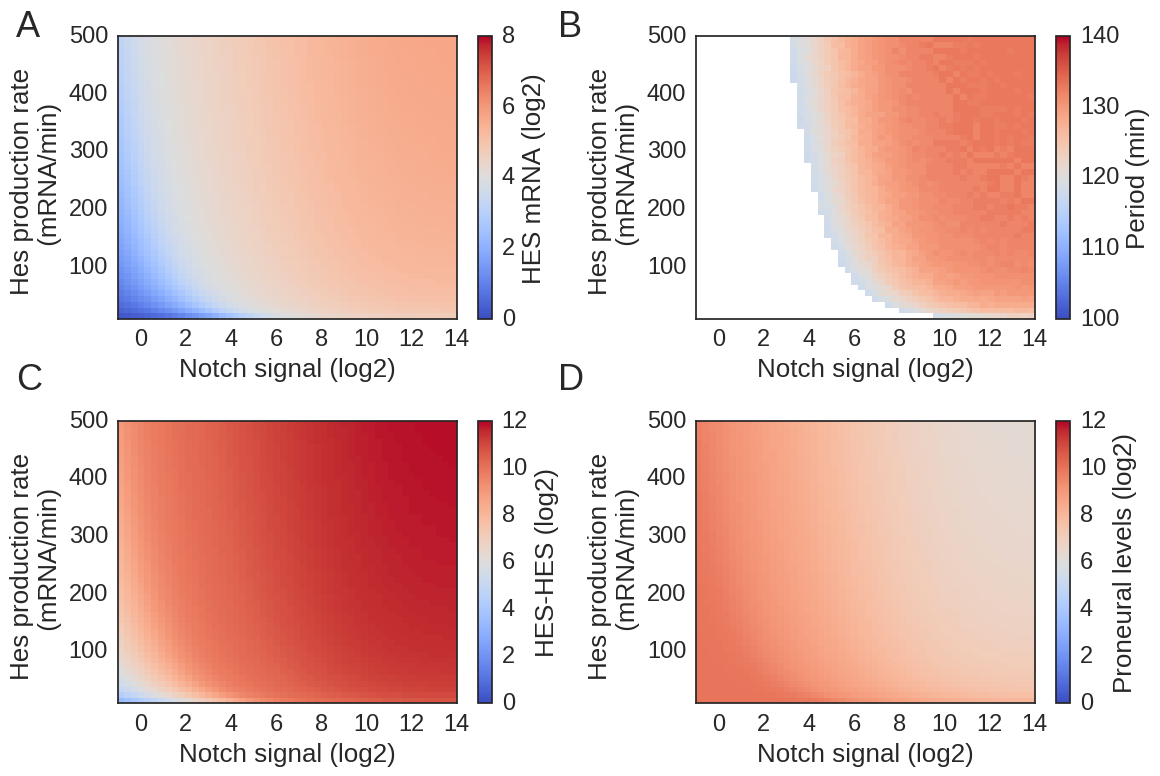

In [5]:
f = plt.subplots(2, 2, figsize=(6.0*2, 4*2), sharey=False)
ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax.text(-.30, 1.00, 'A', fontsize=26, transform=ax.transAxes)
ax.text(1.30, 1.00, 'B', fontsize=26, transform=ax.transAxes)
ax.text(-.30, -.25, 'C', fontsize=26, transform=ax.transAxes)
ax.text(1.30, -.25, 'D', fontsize=26, transform=ax.transAxes)

aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'm0'], label=label, clim=[0, 8], cmap=cmap, ax=ax, 
                  clabel=label['m'], ylog=False)

ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'm0'], label=label, k='T', cmap=cmap, ax=ax, clabel='Period (min)' 
                 ,ylog=False, clim=[100, 140], nc=10)

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['pp'], p_dic, axis=['I', 'm0'], label=label, clim=[0, 12], cmap=cmap, ax=ax, 
                  clabel=label['pp'], ylog=False)

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['aa'], p_dic, axis=['I', 'm0'], label=label, clim=[0, 12], cmap=cmap, ax=ax, 
                  clabel=label['aa'], ylog=False)
plt.tight_layout()
#plt.savefig('../figures/Figure2Suppl_Notch_Hes.pdf', format='pdf')

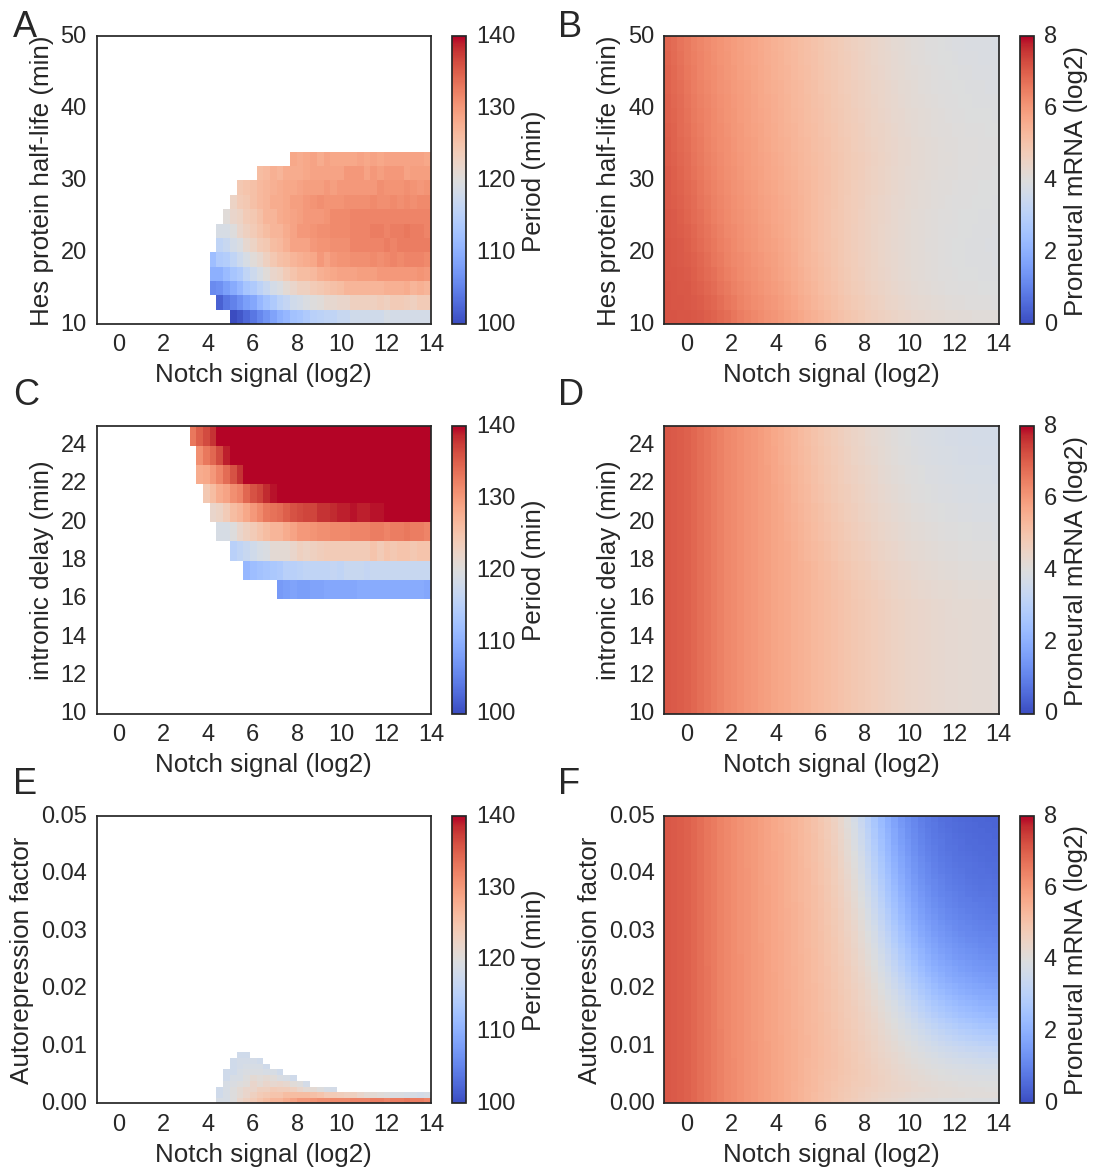

In [6]:
params['ti'] = 25.0
# ------ Setting initial condictions -------------
ic = {'m' : 0.0, 'p' : 0.0, 'pp': 0.0, 'pi': 0.0
     ,'ma': 0.0, 'a' : 0.0, 'aa': 0.0
     }
ic_dic = {'t': np.arange(0.0, params['ti']+params['dt'], params['dt'])}
for k in eqns.keys():
    ic_dic[k] = ic[k]*np.ones(len(ic_dic['t']))
# ------------------------------------------------

dde = dde23(eqns=eqns, params=params, supportcode=mycode)
dde.hist_from_arrays(ic_dic)
dde.set_sim_params(tfinal=params['tf'], RelTol=1e-5, AbsTol=1e-5, dtmax=0.1, dtmin=1e-5, dt0=0.1, MaxIter=1e+8)
dde.run()
dde.params['ti'] = 19.0
params['ti'] = 19.0

s = aux.solve_eqs(dde, trange=trange, dtmax=params['dt'])

f = plt.subplots(1, 2, figsize=(5.7*2, 4*3), sharey=False)
ax = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax.text(-.25, 1.00, 'A', fontsize=26, transform=ax.transAxes)
ax.text(1.38, 1.00, 'B', fontsize=26, transform=ax.transAxes)
ax.text(-.25, -.28, 'C', fontsize=26, transform=ax.transAxes)
ax.text(1.38, -.28, 'D', fontsize=26, transform=ax.transAxes)
ax.text(-.25, -1.63,'E', fontsize=26, transform=ax.transAxes)
ax.text(1.38, -1.63,'F', fontsize=26, transform=ax.transAxes)

m = aux.phase_diagram(dde, p_dic, axis=['I', 'gp'], var=['m', 'pp', 'ma', 'aa'], trange=trange)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'gp'], label=label, k='T', cmap=cmap, ax=ax, clabel='Period (min)' 
                 ,ylog=False, clim=[100, 140], nc=10)
plt.yticks(np.arange(10, 51, 10)/np.log(2), np.arange(10, 51, 10)) 

ax = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['ma'], p_dic, axis=['I', 'gp'], label=label, clim=[0, 8], cmap=cmap, ax=ax, clabel=label['ma']
                 ,ylog=False)
plt.yticks(np.arange(10, 51, 10)/np.log(2), np.arange(10, 51, 10)) 

m = aux.phase_diagram(dde, p_dic, axis=['I', 'ti'], var=['m', 'pp', 'ma', 'aa'], trange=trange)
ax = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'ti'], label=label, k='T', cmap=cmap, ax=ax, clabel='Period (min)' 
                 ,ylog=False, clim=[100, 140], nc=10)
ax = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['ma'], p_dic, axis=['I', 'ti'], label=label, clim=[0, 8], cmap=cmap, ax=ax, clabel=label['ma']
                 ,ylog=False)

m = aux.phase_diagram(dde, p_dic, axis=['I', 'l'], var=['m', 'pp', 'ma', 'aa'], trange=trange)
ax = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'l'], label=label, k='T', cmap=cmap, ax=ax, clabel='Period (min)' 
                 ,ylog=False, clim=[100, 140], nc=10)
ax = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['ma'], p_dic, axis=['I', 'l'], label=label, clim=[0, 8], cmap=cmap, ax=ax, clabel=label['ma']
                 ,ylog=False)
plt.tight_layout()
#plt.savefig('../figures/Figure3_Notch_Hes_Proneurals.pdf', format='pdf')

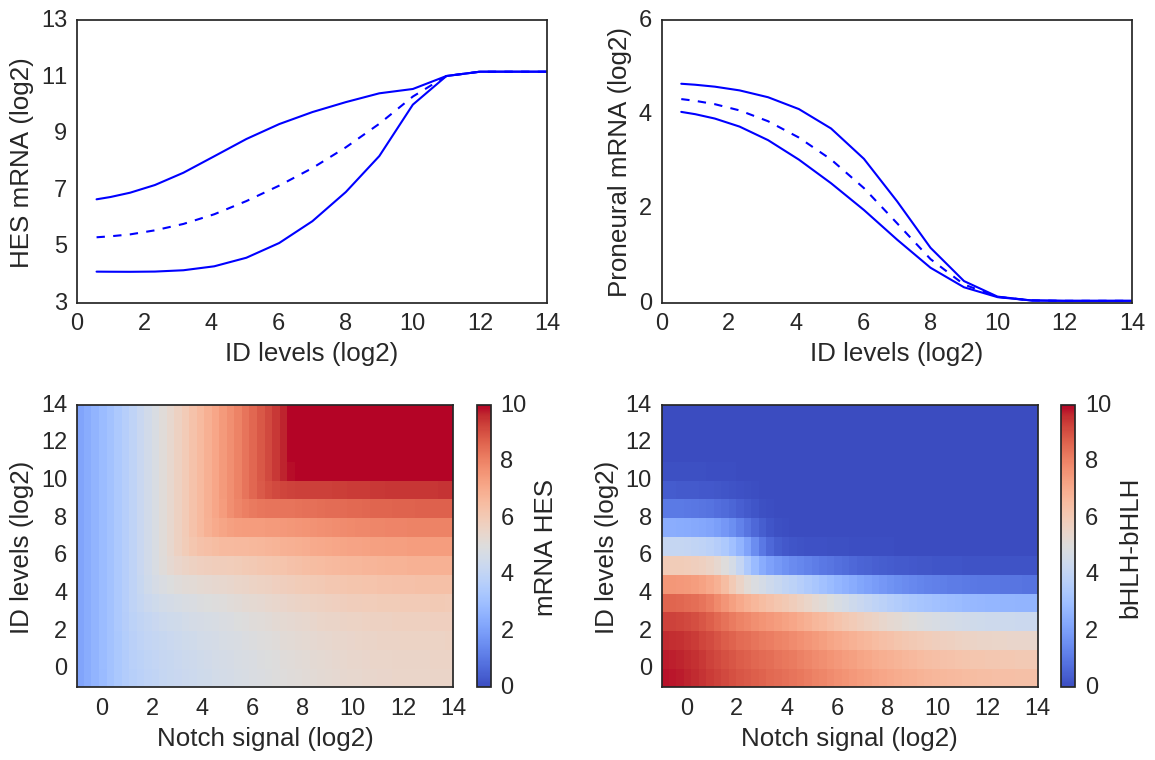

In [7]:
# ------------------- Figure 2B-E ----------------------------
f = plt.subplots(2, 2, figsize=(6*2, 4*2), sharex=False)
ax.text(-.15, 0.96, 'E', fontsize=26, transform=ax.transAxes)
ax.text(1.28, 0.96, 'D', fontsize=26, transform=ax.transAxes)

ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
aux.bifurcation(dde, 'id', p_dic['id'], 'm', trange, label=label, yrange=[3.0, 13.0], ax=ax, xlim=[0,14])
ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.bifurcation(dde, 'id', p_dic['id'], 'ma',trange, label=label, yrange=[0.0, 6.0],  ax=ax, xlim=[0,14])

m = aux.phase_diagram(dde, p_dic, axis=['I', 'id'], var=['m', 'pp', 'ma', 'aa'], trange=trange)
ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='mRNA HES')

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['aa'],p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='bHLH-bHLH')
plt.tight_layout()
#plt.savefig('../figures/Figure4_Notch_Hes_IDs.pdf', format='pdf')

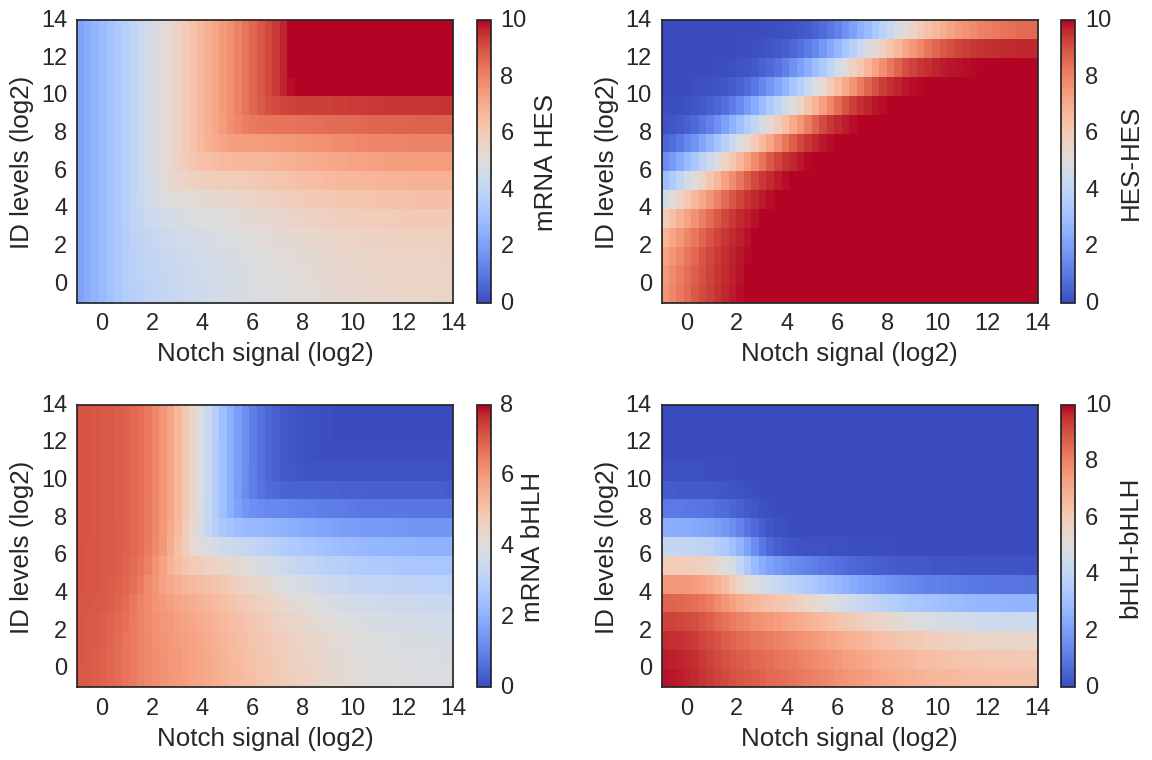

In [8]:
# ------------------- Supplementary figure ----------------------------
f = plt.subplots(2, 2, figsize=(6*2, 4*2), sharex=False, sharey=False)
ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='mRNA HES')

ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['pp'],p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='HES-HES')

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['ma'],p_dic, axis=['I', 'id'], label=label, clim=[0, 8], cmap=cmap, ax=ax, clabel='mRNA bHLH')

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['aa'],p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='bHLH-bHLH')
plt.tight_layout()